# Browse SST for a given area and time period

In [1]:
import os
from glob import glob
from tqdm import tqdm

import xarray as xr
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import pyproj

import pynsitu.geo as geo

In [2]:
if False:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster(cores=14, processes=14) # a tester
    w = cluster.scale(jobs=5)
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()

client = Client(cluster)
client

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/contextlib.py:126: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/contextlib.py:126: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/contextlib.py:126: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50682,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:45686,Total threads: 7
Dashboard: http://127.0.0.1:53167/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:54622,


In [3]:
# sst paths
cersat_dir = "/home/datawork-cersat-public/provider/"
sst_paths = {"viirs_npp": os.path.join(cersat_dir, "ghrsst/satellite/l2p/suomi_npp/viirs/navo-l2p-viirs/data/"),
             "viirs_noaa": os.path.join(cersat_dir, "ghrsst/satellite/l2p/noaa-20/viirs/viirs_n20-ospo-l2p-v2.61/data/"),
             "modis_aqua": os.path.join(cersat_dir, "ghrsst/satellite/l2p/aqua/modis/modis_a-jpl-l2p-v2019.0/data/"),
             "slstr_s3a": os.path.join(cersat_dir, "eumetsat/satellite/l2/sentinel-3a/slstr/s3a_sl_2_wst____o_nr/"),
             "slstr_s3b": os.path.join(cersat_dir, "eumetsat/satellite/l2/sentinel-3b/slstr/s3b_sl_2_wst____o_nr/"),
            }
sst_paths

{'viirs_npp': '/home/datawork-cersat-public/provider/ghrsst/satellite/l2p/suomi_npp/viirs/navo-l2p-viirs/data/',
 'viirs_noaa': '/home/datawork-cersat-public/provider/ghrsst/satellite/l2p/noaa-20/viirs/viirs_n20-ospo-l2p-v2.61/data/',
 'modis_aqua': '/home/datawork-cersat-public/provider/ghrsst/satellite/l2p/aqua/modis/modis_a-jpl-l2p-v2019.0/data/',
 'slstr_s3a': '/home/datawork-cersat-public/provider/eumetsat/satellite/l2/sentinel-3a/slstr/s3a_sl_2_wst____o_nr/',
 'slstr_s3b': '/home/datawork-cersat-public/provider/eumetsat/satellite/l2/sentinel-3b/slstr/s3b_sl_2_wst____o_nr/'}

In [4]:
label="das_201907"

# define a time period of interest
t = pd.Timestamp("2019/07/27")
dt = (-5,5)

# define a region of interest
lon = (4,6)
lat = (41,43)

In [32]:
from itertools import product

def process_sst_one_mission(mission, lon, lat, t, dt=None, debug=False):
    """ Extract AVISO data
    Ref ...

    Parameters
    ----------
    t: date-like object
        date for extraction
    dt: tuple, optional
        time interval in days around t
    """

    t = pd.to_datetime(t)
    if dt is not None:
        days = [t+pd.Timedelta(days=_dt) for _dt in range(*dt)]
    else:
        days = [t]

    # concatenate all potential files
    files = []
    for d in days:
        suff = f"{d.year}/{d.dayofyear:03d}/"
        if "s3" in mission:
            dirs = sorted(glob(os.path.join(sst_paths[mission], suff+"*")))
            for _dir in dirs:
                _files = glob(os.path.join(_dir, d.strftime("%Y%m%d")+"*.nc"))
                assert len(_files)==1, f"non unique data file in {d}"
                files.append(_files[0])
        else:
            files = files + sorted(glob(os.path.join(sst_paths[mission], suff+"*.nc")))
    #                                     f"{d.year}/{d.dayofyear:03d}/"+d.strftime("%Y%m%d")+"*.nc")))
    
    if debug:
        return files
    
    if len(files)==0:
        print("No file match, was mission operational at time of interest?")
        return None
    
    futures = client.map(_process_file, files, lon=lon, lat=lat, mission=mission)
    
    # blocking
    D = client.gather(futures)
    D = [d for d in D if d is not None]
    print(f"{len(D)} snapshot compatible")    

    # concatenate into one dataset
    ds = xr.concat(D, "time")    
    # sort by time and chunk
    ds = ds.sortby("time").chunk(dict(time="auto"))
    
    # store
    zarr = os.path.join(os.getenv("SCRATCH"), label+"_sst_"+mission)+".zarr"
    ds.to_zarr(zarr, mode="w")
    
    return ds

def _process_file(file, lon=None, lat=None, mission=None):
    """analyze sst file to find whether it is close to the region of interest"""

    assert (lon is not None) and (lat is not None), "lon/lat kwargs must be provided"
    assert mission is not None, "mission must be provided"
    
    ds = xr.open_dataset(file)
    
    if mission in ['viirs_npp']:
        ds = ds.where(ds.lon>-200)

    # approximate distance to point of interest
    #x0, y0 = proj.transform(lon0, lat0)
    #d = np.sqrt((ds.x-x0)**2+(ds.y-y0)**2)
    # criterium based on corner points
    _d = xr.concat([geo.haversine(_lon, _lat, ds.lon, ds.lat)*1e3 
                    for _lon, _lat in product(lon, lat)], "points",
                  )
    #_d = geo.haversine(lon0, lat0, ds.lon, ds.lat)*1e3

    # decide whether 
    d_threshold = 10*1e3 # in meters
    if _d.where(_d<d_threshold, drop=True).size>0:
        return process_sst_snapshot(ds, lon[0], lat[0], mission)
    else:
        return None

def process_sst_snapshot(ds, lon0, lat0, mission):
    
    ds = ds.reset_coords()
    
    #ds = ds.where(ds.lon>-200)
    #ds = ds.where(ds.lat>-200)

    # project on a local coordinate system
    lonc, latc = float(ds.lon.mean()), float(ds.lat.mean())

    # project
    proj = geo.projection(lonc, latc)
    x0, y0 = proj.lonlat2xy(lon0, lat0)
    x, y = proj.lonlat2xy(ds.lon, ds.lat)
    ds["x"] = (("nj", "ni"), x)
    ds["y"] = (("nj", "ni"), y)
    
    if mission in ['viirs_npp']:
        # fix bad positions
        _ds = ds[["x","y"]].stack(point=["ni","nj"])
        _ds = _ds.where(~np.isnan(_ds.x), drop=True)
        c = _polyfit(_ds.ni, _ds.nj, _ds.x)
        ds["xr"] = _poly2Dreco(ds.nj*0+ds.ni, ds.nj+ds.ni*0, c)
        c = _polyfit(_ds.ni, _ds.nj, _ds.y)
        ds["yr"] = _poly2Dreco(ds.nj*0+ds.ni, ds.nj+ds.ni*0, c)
        # recompute coordinates
        lon, lat = proj.xy2lonlat(ds.xr, ds.yr)
        ds["lonr"] = (("nj","ni"), lon)
        ds["latr"] = (("nj","ni"), lat)

        #
        ds["x"] = ds["x"].where( ~np.isnan(ds.x), other=ds.xr )
        ds["y"] = ds["y"].where( ~np.isnan(ds.y), other=ds.yr )
        ds["lon"] = ds["lon"].where( ~np.isnan(ds.lon), other=ds.lonr )
        ds["lat"] = ds["lat"].where( ~np.isnan(ds.lat), other=ds.latr )
    
    ds = (ds
          .set_coords(["x", "y", "lon", "lat"])
          .drop(["xr", "yr", "lonr", "latr"], errors="ignore")
         )

    return ds

def _polyfit(X, Y, Z):
    A = np.array([X*0+1, X, Y, X**2, X**2*Y, X**2*Y**2, Y**2, X*Y**2, X*Y]).T
    B = Z
    coeff, r, rank, s = np.linalg.lstsq(A, B, rcond=None)
    return coeff

def _poly2Dreco(X, Y, c):
    return (c[0] + X*c[1] + Y*c[2] + X**2*c[3] + X**2*Y*c[4] + X**2*Y**2*c[5] + 
           Y**2*c[6] + X*Y**2*c[7] + X*Y*c[8])

In [34]:
# mission of interest
#mission = 'viirs_npp'
#mission = 'viirs_noaa'
#mission = 'modis_aqua'
mission = 'slstr_s3a'
#mission = 'slstr_s3b'

ds = process_sst_one_mission(mission, lon, lat, t, dt=dt)

# debug
#files = process_sst_one_mission(mission, lon, lat, t, dt=dt, debug=True)
#ds = xr.open_dataset(files[0])
#ds.sea_surface_temperature.plot(x="lon", y="lat")

24 snapshot compatible


In [9]:
# reload
ds = xr.open_zarr(zarr).persist()

### plot overviews

In [ ]:
dl = 1
bounds = (lon[0]-dl, lon[1]+dl, lat[0]-dl, lat[1]+dl)
vmin, vmax = 19, 28

#t = ds.time[0]

for t in ds.time:

    _da = ds.sel(time=t).sea_surface_temperature - 273.15 # Kelvin to Celsius
    fig, ax, crs = geo.plot_map(coast="10m", land="10m", bounds=bounds, rivers=None)
    _da.plot(x="lon", y="lat", ax=ax, transform=crs, vmin=vmin, vmax=vmax)
    # store figure
    fig_file = os.path.join(os.getenv("SCRATCH"), "figs", 
                            str(t.dt.strftime("%Y%m%d_%H%M%S").values+".png"),
                           )
    fig.savefig(fig_file, dpi=300)
    plt.close(fig)
    print(fig_file)

/home1/scratch/aponte/figs/20190730_121311.png


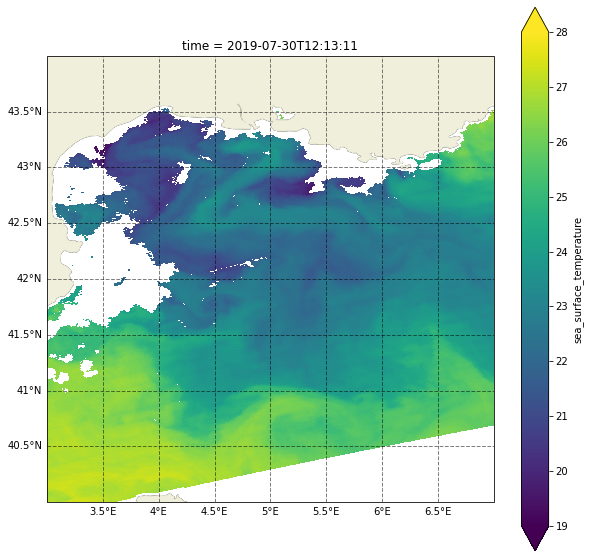

In [15]:

t = ds.time.sel(time="20190730T121311", method="nearest")

_da = ds.sel(time=t).sea_surface_temperature - 273.15 # Kelvin to Celsius
fig, ax, crs = geo.plot_map(coast="10m", land="10m", bounds=bounds, rivers=None)
_da.plot(x="lon", y="lat", ax=ax, transform=crs, vmin=vmin, vmax=vmax)
# store figure
fig_file = os.path.join(os.getenv("SCRATCH"), "figs", 
                        str(t.dt.strftime("%Y%m%d_%H%M%S").values+".png"),
                       )
print(fig_file)

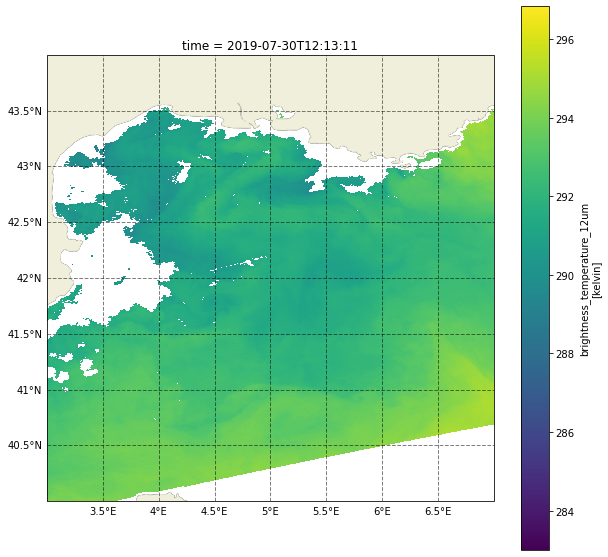

In [18]:
_da = ds.sel(time=t).brightness_temperature_12um # - 273.15 # Kelvin to Celsius
fig, ax, crs = geo.plot_map(coast="10m", land="10m", bounds=bounds, rivers=None)
_da.plot(x="lon", y="lat", ax=ax, transform=crs) #, vmin=vmin, vmax=vmax

In [36]:
def load_sst_from_time(mission, t):
    
    t = pd.to_datetime(t.values)

    files = glob(os.path.join(sst_paths[mission], 
                              f"{t.year}/{t.dayofyear:03d}/"+t.strftime("%Y%m%d%H%M%S")+"*.nc"
                             ),
                )
    assert len(files)==1, "multiple files matching: "+", ".join(files)
    nc = files[0]
    ds1 = xr.open_dataset(nc)
    return ds1

ds1 = load_sst_from_time(mission, t)

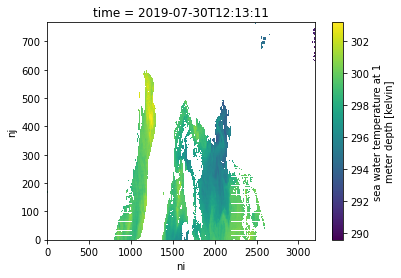

In [33]:
ds1.sea_surface_temperature.plot()

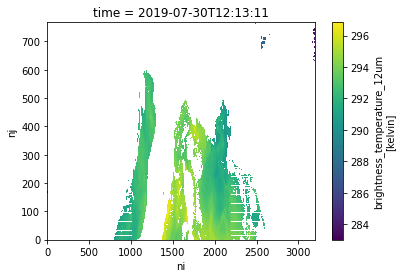

In [32]:
ds1.brightness_temperature_12um.plot()

In [ ]:
ds1.brightness_temperature_12um.plot()

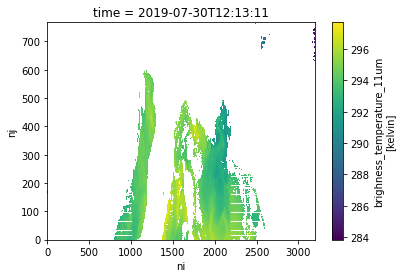

In [34]:
ds1.brightness_temperature_11um.plot()

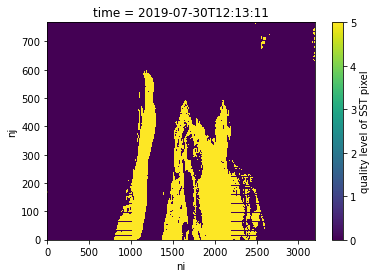

In [37]:
ds1.quality_level.plot()

<xarray.Dataset>
Dimensions:                      (nj: 768, ni: 3200, time: 1)
Coordinates:
    lat                          (nj, ni) float32 42.49 42.49 ... 41.73 41.72
    lon                          (nj, ni) float32 28.79 28.77 ... -9.699 -9.717
  * time                         (time) datetime64[ns] 2019-07-30T12:13:11
Dimensions without coordinates: nj, ni
Data variables: (12/14)
    sea_surface_temperature      (time, nj, ni) float32 nan nan nan ... nan nan
    sst_dtime                    (time, nj, ni) float32 0.0 0.0 ... 83.5 83.5
    sses_bias                    (time, nj, ni) float32 nan nan nan ... nan nan
    sses_standard_deviation      (time, nj, ni) float32 nan nan nan ... nan nan
    dt_analysis                  (time, nj, ni) float32 nan nan nan ... nan nan
    wind_speed                   (time, nj, ni) float32 nan nan nan ... nan nan
    ...                           ...
    satellite_zenith_angle       (time, nj, ni) float32 0.0 70.0 ... 70.0 70.0
    l2p_flags                    (time, nj, ni) float32 512.0 512.0 ... 512.0
    quality_level                (time, nj, ni) float32 0.0 0.0 0.0 ... 0.0 0.0
    brightness_temperature_4um   (time, nj, ni) float32 nan nan nan ... nan nan
    brightness_temperature_11um  (time, nj, ni) float32 nan nan nan ... nan nan
    brightness_temperature_12um  (time, nj, ni) float32 nan nan nan ... nan nan
Attributes: (12/47)
    Conventions:                CF-1.6
    title:                      VIIRS L2P SST
    summary:                    Sea Surface temperature retrievals produced a...
    references:                 NAVOCEANO MCSST
    institution:                NAVO
    history:                    Created with VIIRSseatemp on  2019/07/30 at 1...
    ...                         ...
    project:                    Group for High Resolution Sea Surface Tempera...
    publisher_name:             The GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L2P
    cdm_data_type:              swath

In [ ]:
ds = (xr.load_dataset(files[0], **rkwargs)
       .sel(**kwargs)
      )
D.append(ds)
ds = xr.concat(D, dim="time", combine_attrs="drop_conflicts") # drop attributes that vary
ds = ds.rename(time=suffix+"time", longitude=suffix+"lon", latitude=suffix+"lat")
return ds

In [ ]:
def get_aviso_one_obs(ds_obs, dt):
    """ load aviso for one collocation """
    
    # load data
    aviso = sat.load_aviso(ds_obs.time.values, dt, suffix="aviso_")
    
    # interpolate on local grid
    sla = aviso.sla.interp(aviso_lon=ds_obs.box_lon,
                           aviso_lat=ds_obs.box_lat,
                          )
    
    # convert to dataset and massage in order to concatenate properly in get_aviso
    ds = sla.to_dataset()
    ds["aviso_dates"] = ds.aviso_time
    ds = (ds
          .drop(["aviso_time", "time", "lon", "lat", "aviso_lon", "aviso_lat"]) # forget about actual dates in time coordinate
          .rename(sla="aviso_sla")
    )
    
    return ds

______

In [32]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
